In [1]:
import pandas as pd
from datetime import datetime, timedelta

from src import *
pd.set_option('display.max_rows', None)

# Parameters

These parameters configure various things such as the relative location of data files, which date is being analysed
and the assumed generation period for an infection.

In [2]:
ALL_VIC_CASES='archive/2021-07-12/all-vic-cases.csv'
QUARANTINE='archive/2021-07-16/quarantine.csv'
GENERATION_DAYS=5
ENABLE_MELBOURNE_ANIMATION=False

TODAY=datetime.today().strftime("%Y-%m-%d")
LAST_WEEK=add_days(TODAY, -7)

RUN_DATE=TODAY
#RUN_DATE='2021-07-25'
PREV_DAY=add_days(RUN_DATE, -1)
NEXT_WEEK=add_days(RUN_DATE, 7)
PREV_WEEK=add_days(RUN_DATE, -7)
PREV_FORTNIGHT=add_days(RUN_DATE, -14)

NSW_6_MONTHS=f"archive/{RUN_DATE}/last-6-months-nsw.csv"
NSW_14_DAYS=f"archive/{RUN_DATE}/last-14-days-nsw.csv"

# Data Preparation

**sweep_downloads()** moves files from the $HOME/Downloads directory into today's archive directory. Thses should first be
downloaded from the "Last 14 days (new)" and "Last 6 months (true)" panels of the NSW Transmission Sources section of [covid19data.com.au](https://www.covid19data.com.au/nsw)

In [3]:
sweep_downloads(TODAY)

Next, we load the data from the files and merge the 14-day data with the 6 month data.

In [4]:
nsw_df = update_df(load_data(NSW_6_MONTHS),load_data(NSW_14_DAYS))
vic_df = load_vic_data(ALL_VIC_CASES)
quarantine_df = load_quarantine(QUARANTINE)

Next, we truncate and refindex the data frames to each outbreak.

In [5]:
avalon = select_outbreak(nsw_df[(nsw_df['date'] >= '2020-12-17') & (nsw_df['date'] <= '2021-01-16')], generation_days=GENERATION_DAYS)
bondi = select_outbreak(nsw_df[(nsw_df['date'] >= '2021-06-17')], generation_days=GENERATION_DAYS)
vic_outbreak = select_outbreak(vic_df[(vic_df['date'] >= '2020-05-27') & (vic_df['date'] <= '2020-10-29')], generation_days=GENERATION_DAYS)

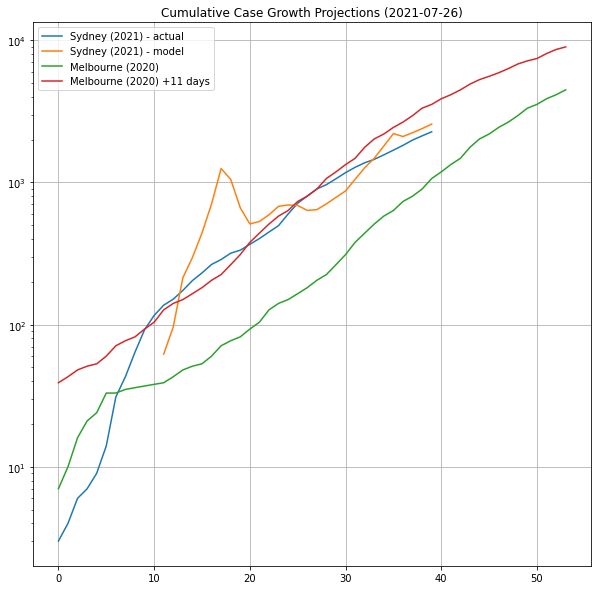

In [6]:
output=pd.DataFrame(columns=['cumulative', 'min', 'vic'])
output[['min', 'cumulative']] = bondi[['min','cumulative']]
output=output.reindex([r for r in range(0, len(bondi)+14)])
output['vic'] = vic_outbreak['cumulative']
x=11
output['vic-offset'] = vic_outbreak['cumulative'].shift(-x)
ax=output.plot(figsize=(10,10))
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Cumulative Case Growth Projections ({RUN_DATE})')
ax.legend([
    'Sydney (2021) - actual', 
    'Sydney (2021) - model', 
    'Melbourne (2020)',
    f'Melbourne (2020) +{x} days'
])
ax.figure.savefig(f'archive/{RUN_DATE}/cumulative-partial.png')
_=_

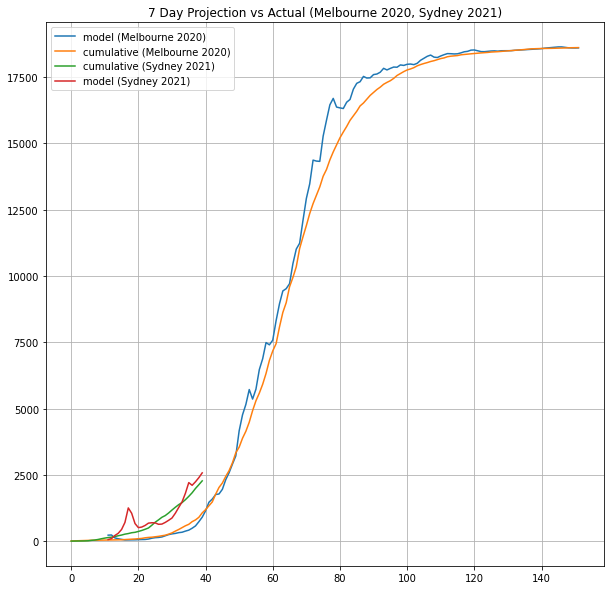

In [7]:
df=vic_outbreak
ax=df[['min', 'cumulative']].plot(figsize=(10,10))
#ax.set_yscale('log')
ax.grid()
ax.plot(bondi['cumulative'])
ax.plot(bondi['min'])
ax.legend(['model (Melbourne 2020) ', 'cumulative (Melbourne 2020)','cumulative (Sydney 2021)',  'model (Sydney 2021) '])
ax.set_title("7 Day Projection vs Actual (Melbourne 2020, Sydney 2021)")
ax.figure.savefig(f'archive/{RUN_DATE}/cumulative-full.png')
_=_

In [8]:
VIC_EXTRA_DAYS=0

vic_growth_params=derive_growth_params(vic_outbreak[(vic_outbreak.index >= 70) & (vic_outbreak.index < 120)], generation_days=GENERATION_DAYS)
bondi_growth_params=derive_growth_params(bondi.tail(8), generation_days=GENERATION_DAYS)
N=1
bondi_growth_params_3=derive_growth_params(bondi.tail(8+N).head(8), generation_days=GENERATION_DAYS)
gp=derive_growth_params(bondi[(bondi.index>15)])
bondi_projection_1=select_outbreak(project_ols_growth_rate_min(bondi, 84, vic_growth_params[1]))
bondi_projection_2=select_outbreak(project_ols_growth_rate_min(bondi, 110, gp[1]))
bondi_projection_3=select_outbreak(project_ols_growth_rate_min(bondi.head(len(bondi)-N), 84+N, gp[1]))


vic_partial=vic_outbreak.head(len(bondi)+VIC_EXTRA_DAYS)
vic_partial_growth_params=derive_growth_params(vic_partial)
vic_projection=select_outbreak(project_ols_growth_rate_min(vic_partial, len(vic_outbreak)-len(bondi)-VIC_EXTRA_DAYS, vic_partial_growth_params[1]), generation_days=GENERATION_DAYS)

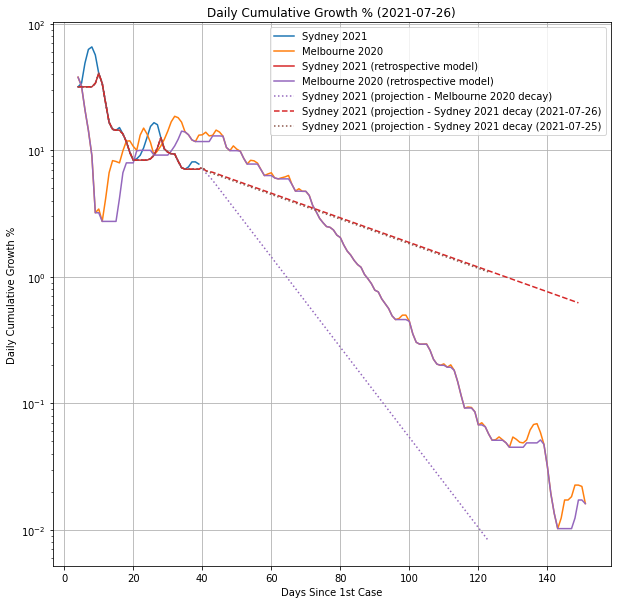

In [9]:
gp=GrowthPlot(RUN_DATE)
gp.add(bondi, offset=0, legend="Sydney 2021")
#gp.add(avalon, offset=0, legend="Avalon 2020")
gp.add(vic_outbreak, offset=0, legend="Melbourne 2020")
gp.ax.plot(bondi['ols-growth-rate-min'],color="C3")
gp.ax.plot(vic_outbreak['ols-growth-rate-min'], color="C4")
gp.ax.plot(bondi_projection_1['ols-growth-rate-min'], linestyle='dotted', color='C4')
gp.ax.plot(bondi_projection_2['ols-growth-rate-min'], linestyle='dashed', color='C3')
gp.ax.plot(bondi_projection_3['ols-growth-rate-min'], linestyle='dotted', color='C5')
gp.ax.set_yscale('log')
gp.legend = gp.legend+[
    'Sydney 2021 (retrospective model)', 
    'Melbourne 2020 (retrospective model)', 
    'Sydney 2021 (projection - Melbourne 2020 decay)',
    f'Sydney 2021 (projection - Sydney 2021 decay ({RUN_DATE})',
    f'Sydney 2021 (projection - Sydney 2021 decay ({PREV_DAY})'
]
gp.ax.legend(gp.legend)
gp.ax.figure.savefig(f'archive/{RUN_DATE}/cumulative-growth.png')

#gp.add(vic_outbreak.shift(-11), offset=0, legend="Melbourne 2020 (shifted)")
_=_

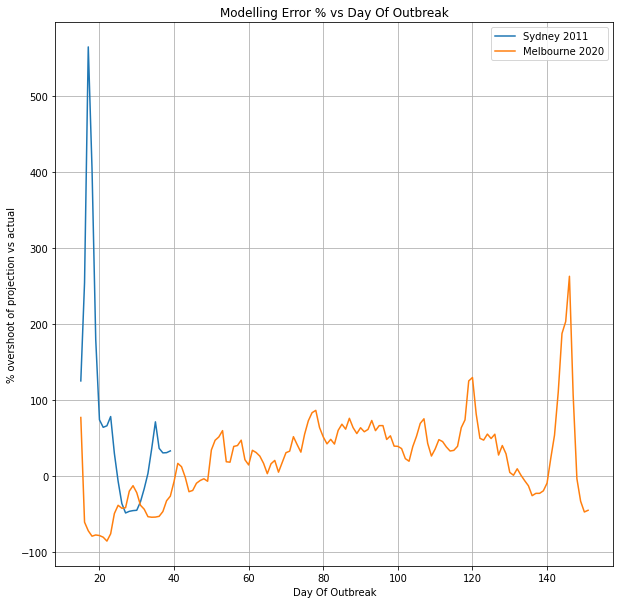

In [10]:
output=pd.DataFrame()
output['vic'] = modeling_errors(vic_outbreak)
output["vic"]
output["bondi"] = modeling_errors(bondi)
#output["avalon"] = modeling_errors(avalon)
                                    
ax=output.loc[output.index >= 15, ['bondi', 'vic', ]].plot(figsize=(10,10))
ax.grid()                         
ax.set_title("Modelling Error % vs Day Of Outbreak")
ax.set_xlabel("Day Of Outbreak")
ax.set_ylabel("% overshoot of projection vs actual")
ax.legend(['Sydney 2011', 'Melbourne 2020'])
ax.figure.savefig(f'archive/{RUN_DATE}/modellng-error.png')
_=_

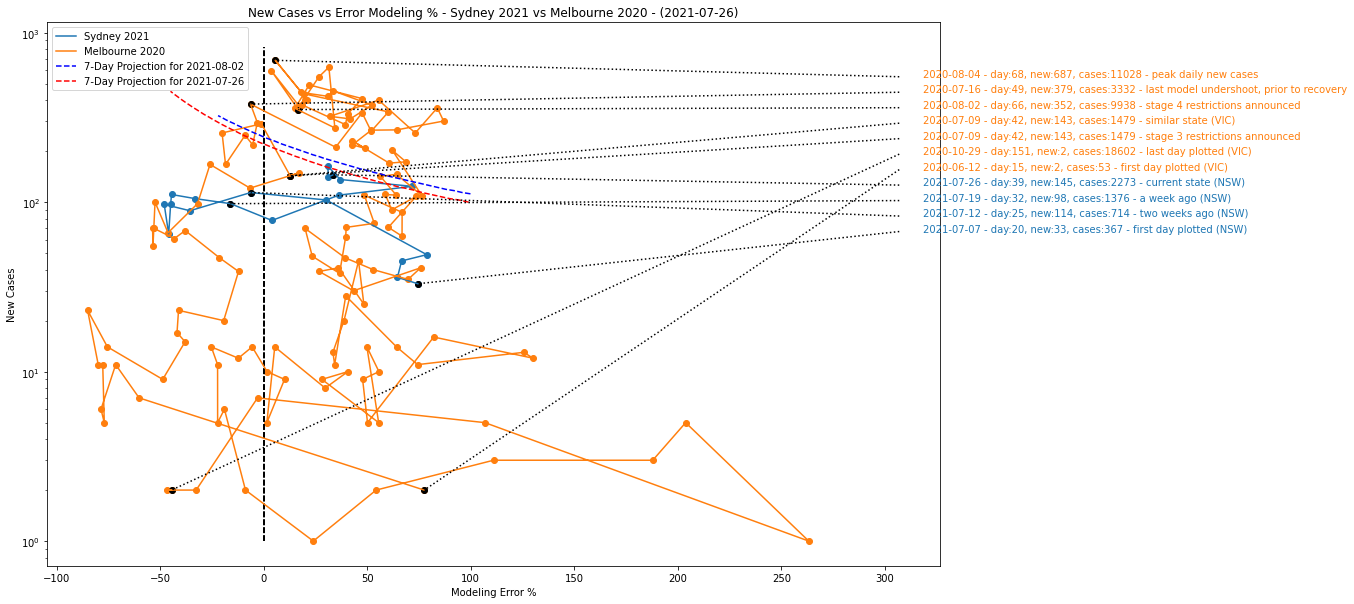

In [11]:
plot_vic=True

pp = PhasePlot(f"New Cases vs Error Modeling % - Sydney 2021 vs Melbourne 2020 - ({RUN_DATE})")

bondi_idx=pp.add(bondi, offset=20, legend="Sydney 2021", color="C0") # 20
if plot_vic:
    vic_idx=pp.add(vic_outbreak, offset=15, legend="Melbourne 2020", color="C1") # 15

pp.add_horizon(horizon(bondi, 7), legend=f"7-Day Projection for {NEXT_WEEK}", color="blue")
pp.add_horizon(horizon(bondi.head(len(bondi)-7), 7), legend=f"7-Day Projection for {RUN_DATE}", color="red")
# for i in range(0,7):
#     pp.add_horizon(horizon(bondi.head(len(bondi)-7-i),7), legend=f"today - as projected {7+i} days ago", color=f"C{i}")


if plot_vic:
    first_case=pp.frames[vic_idx].head(1)['date']
    last_case=pp.frames[vic_idx].tail(1)[['date', 'total', 'err']]

    pp.add_label(vic_idx, "2020-08-04", "peak daily new cases")
    pp.add_label(vic_idx, "2020-07-16", "last model undershoot, prior to recovery")
    pp.add_label(vic_idx, "2020-08-02", "stage 4 restrictions announced")
    pp.add_label(vic_idx, "2020-07-09", "similar state (VIC)")
    pp.add_label(vic_idx, "2020-07-09", "stage 3 restrictions announced")
    pp.add_label(vic_idx, last_case.values[0][0], f"last day plotted (VIC)")
    pp.add_label(vic_idx, first_case.values[0], f"first day plotted (VIC)")

    # pp.add_label(vic_idx, "2020-08-09", "1 week after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-08-16", "2 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-08-23", "3 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-08-30", "4 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-09-06", "5 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-09-13", "6 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-09-20", "7 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-09-27", "8 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-10-03", "9 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-10-10", "10 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-10-17", "11 weeks after stage 4 restrictions announced")
    # pp.add_label(vic_idx, "2020-10-24", "12 weeks after stage 4 restrictions announced")

first_case_nsw=pp.frames[bondi_idx].head(1)['date']
pp.add_label(bondi_idx, RUN_DATE, "current state (NSW)")
pp.add_label(bondi_idx, PREV_WEEK, "a week ago (NSW)")
pp.add_label(bondi_idx, PREV_FORTNIGHT, "two weeks ago (NSW)")
pp.add_label(bondi_idx, first_case_nsw.values[0], f"first day plotted (NSW)")    
    
pp.ax.figure.savefig(f'archive/{RUN_DATE}/hedgehog.png')
_=_

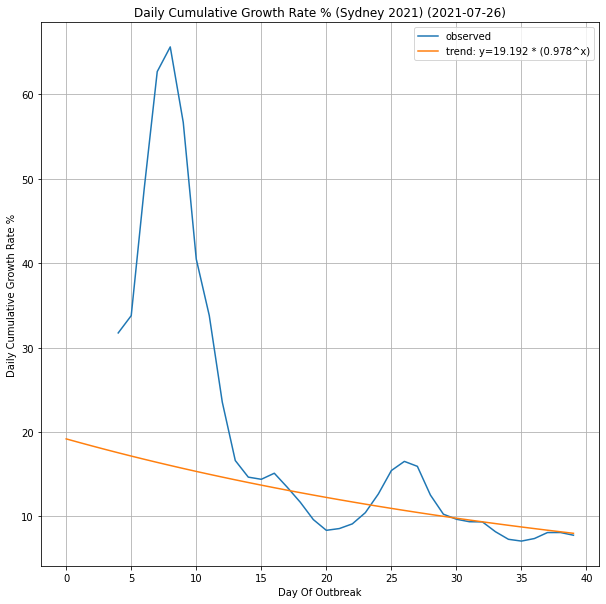

In [12]:
gp=derive_growth_params(bondi[(bondi.index>15)])
ax=bondi["ols-growth-rate"].plot(figsize=(10,10))
ax.plot((gp[1]**bondi.index)*gp[0])
ax.set_title(f"Daily Cumulative Growth Rate % (Sydney 2021) ({RUN_DATE})")
ax.set_xlabel("Day Of Outbreak")
ax.set_ylabel("Daily Cumulative Growth Rate %")
#ax.set_yscale("log")
ax.legend(["observed", f"trend: y={round(gp[0],3)} * ({round(gp[1],3)}^x)"])
ax.grid()
ax.figure.savefig(f'archive/{RUN_DATE}/growth-rate-trend.png')

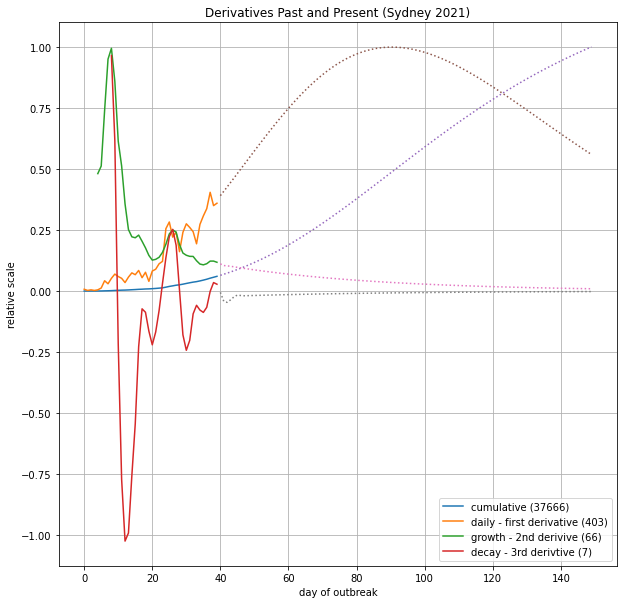

In [13]:
df=select_outbreak(project_ols_growth_rate_min(bondi, 110, gp[1]))
ax=plot_derivatives(df, len(bondi), "Sydney 2021")
ax.figure.savefig(f'archive/{RUN_DATE}/derivatives-sydney-partial.png')

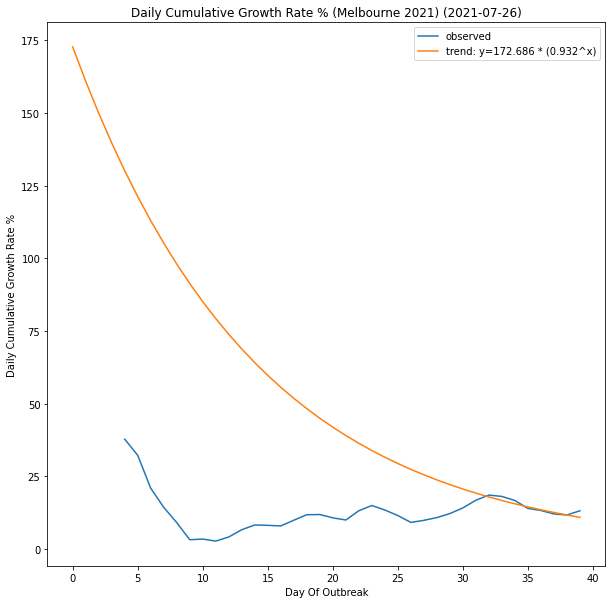

In [14]:
df=vic_partial
gp=derive_growth_params(df[df.index>30])
ax=df["ols-growth-rate"].plot(figsize=(10,10))
ax.plot((gp[1]**bondi.index)*gp[0])
ax.set_title(f"Daily Cumulative Growth Rate % (Melbourne 2021) ({RUN_DATE})")
ax.set_xlabel("Day Of Outbreak")
ax.set_ylabel("Daily Cumulative Growth Rate %")
ax.legend(["observed", f"trend: y={round(gp[0],3)} * ({round(gp[1],3)}^x)"])
#ax.figure.savefig(f'archive/{RUN_DATE}/growth-rate-trend.png')

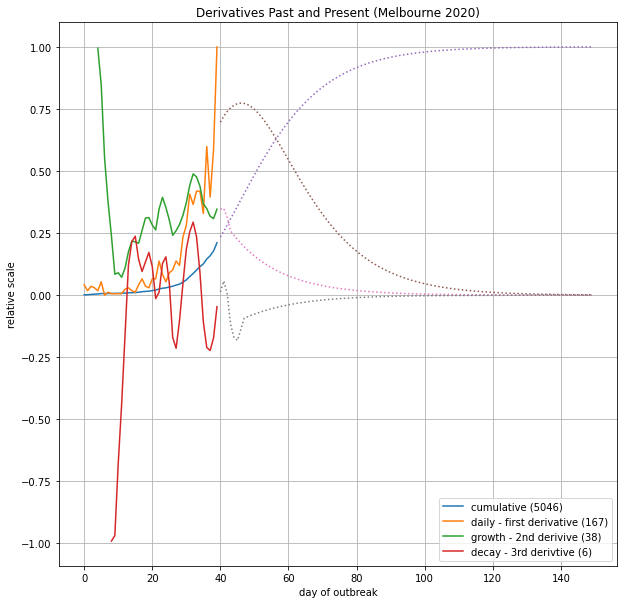

In [15]:
df=select_outbreak(project_ols_growth_rate_min(vic_partial, 110, gp[1]))
ax=plot_derivatives(df, len(vic_partial), dataset="Melbourne 2020")
#ax.figure.savefig(f'archive/{RUN_DATE}/derivatives-melbourne-partial.png')

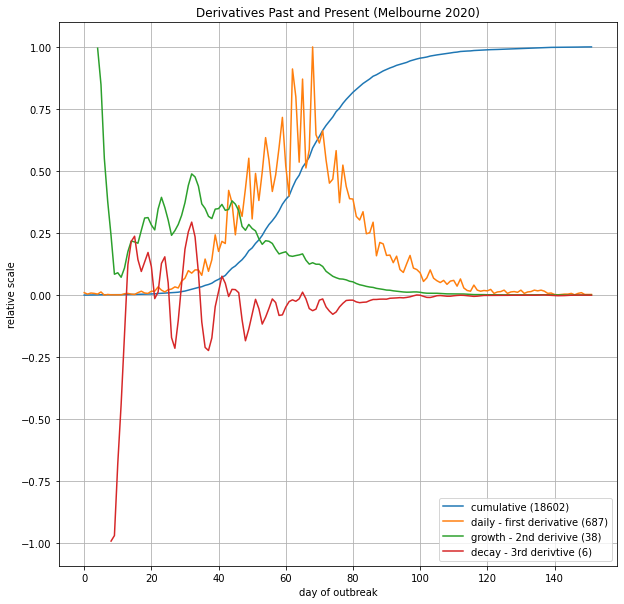

In [16]:
ax=plot_derivatives(vic_outbreak, None, dataset="Melbourne 2020")
ax.figure.savefig(f'archive/{RUN_DATE}/derivatives-melbourne-full.png')

In [17]:
#pd.set_option('max_colwidth', None)
pd.set_option('float_format', None)
bondi[[
#    "date",
    "cumulative", 
    "total", 
    "ols-growth-rate", 
    "ols-growth-rate-decay",  
    "doubling-period",
    "one-day-error", 
    "one-day-projection-cumulative", 
    "one-day-projection-total", 
]].tail(8)

,cumulative,total,ols-growth-rate,ols-growth-rate-decay,doubling-period,one-day-error,one-day-projection-cumulative,one-day-projection-total
32,1376.0,98.0,9.360090,-0.653477,7.746754,-22.0,1505.0,129.0
33,1454.0,78.0,8.198196,-0.407615,8.796897,-51.0,1573.0,119.0
34,1564.0,110.0,7.297870,-0.545186,9.840443,-9.0,1678.0,114.0
35,1688.0,124.0,7.085372,-0.612376,10.125412,10.0,1808.0,120.0
36,1824.0,136.0,7.389565,-0.465954,9.722537,16.0,1959.0,135.0
37,1987.0,163.0,8.094974,-0.010547,8.904764,28.0,2148.0,161.0
38,2128.0,141.0,8.100952,0.243268,8.898442,-20.0,2300.0,172.0
39,2273.0,145.0,7.780471,0.195618,9.251053,-27.0,2450.0,177.0


/usr/local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


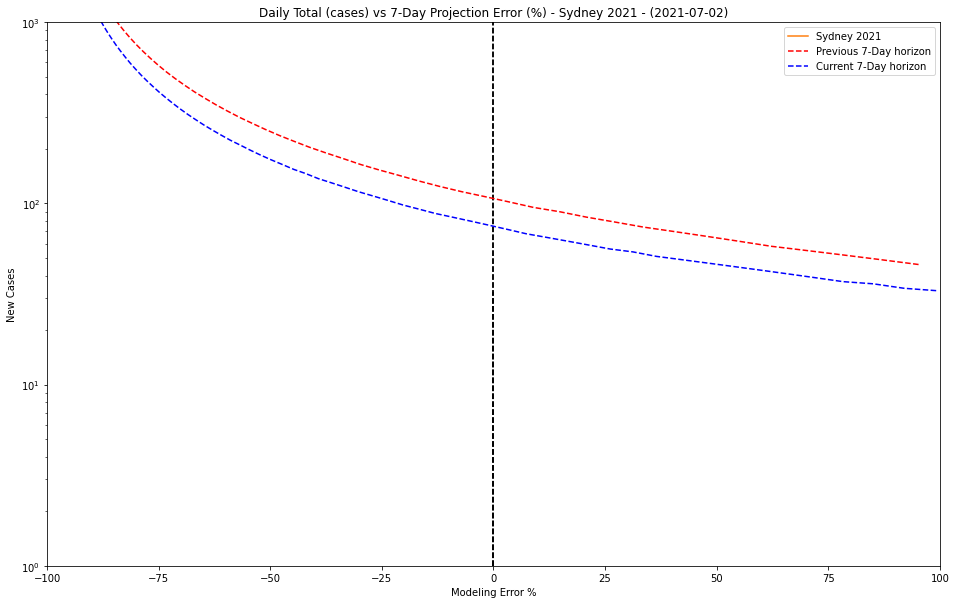

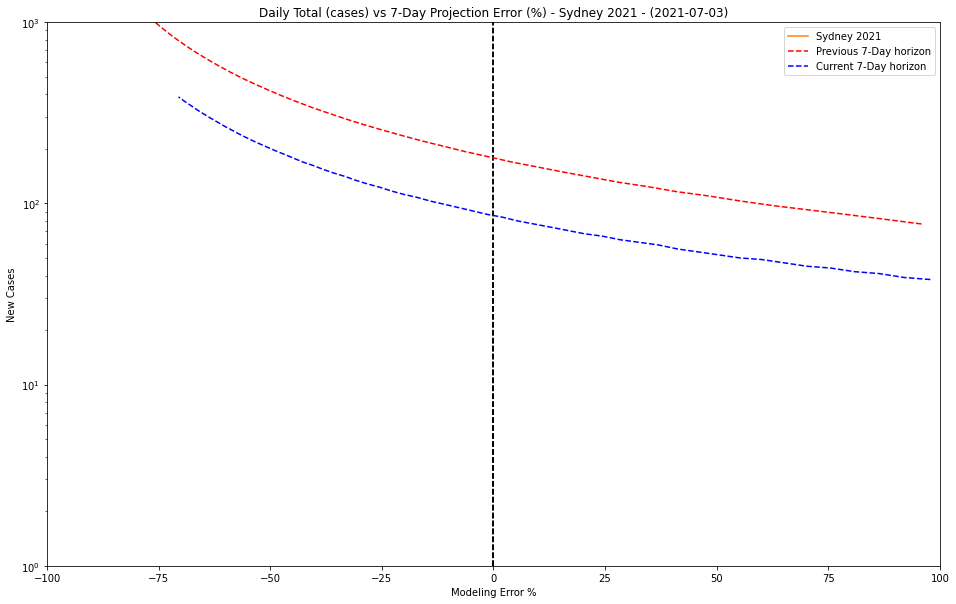

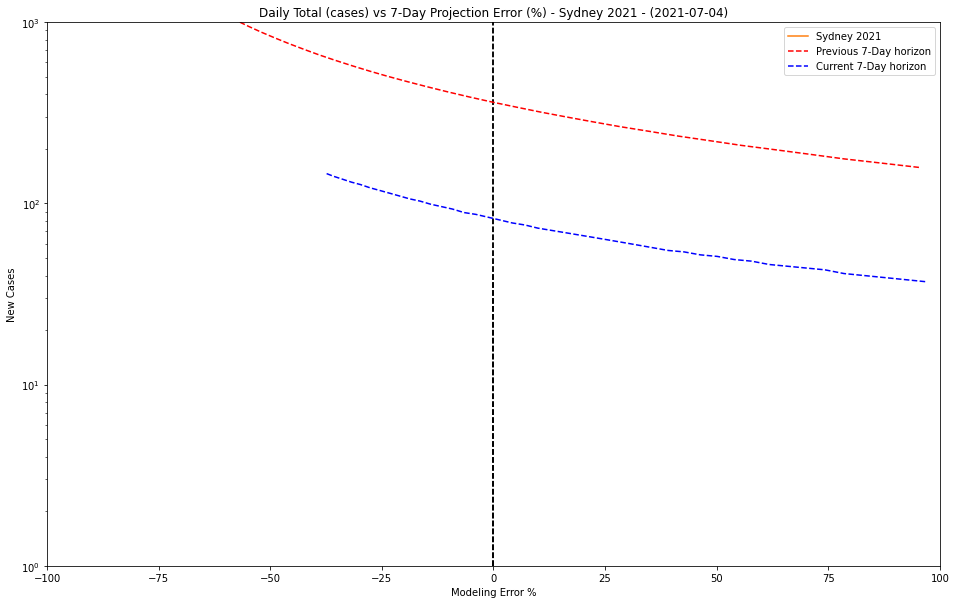

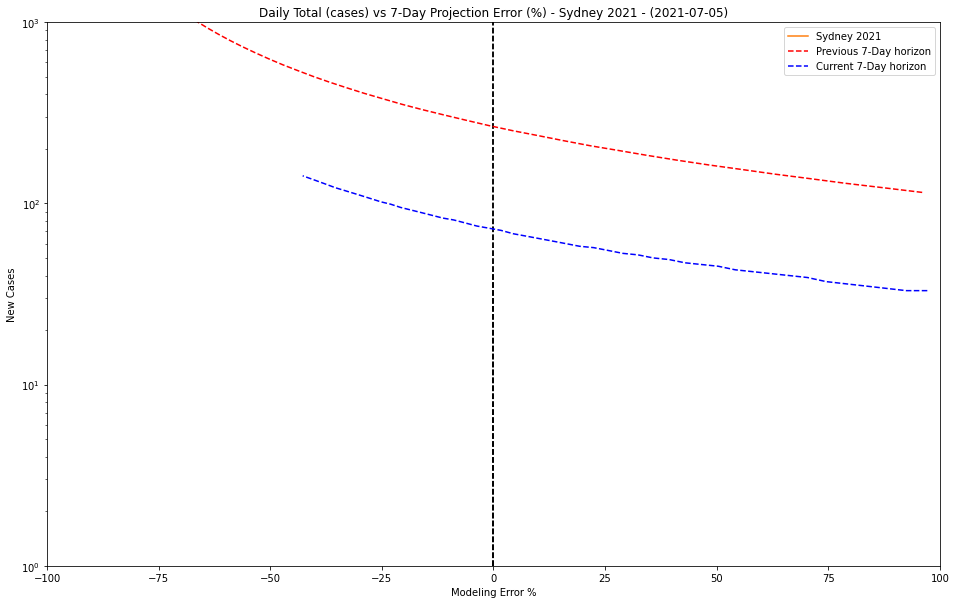

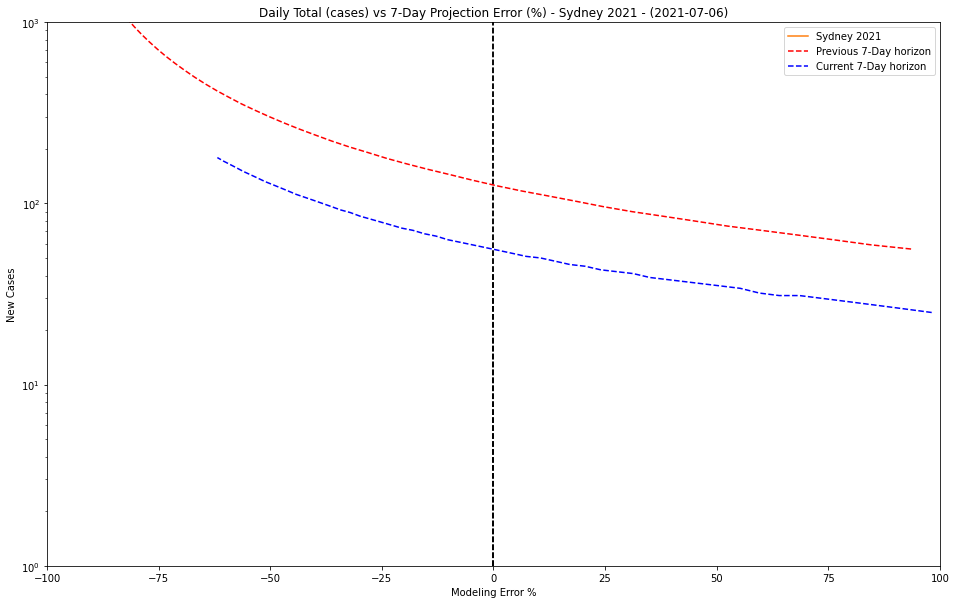

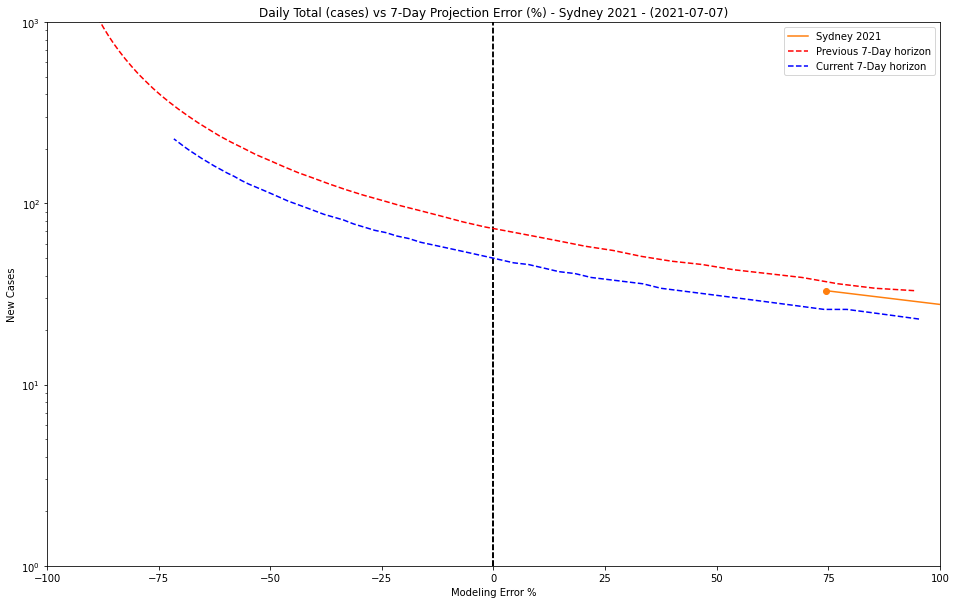

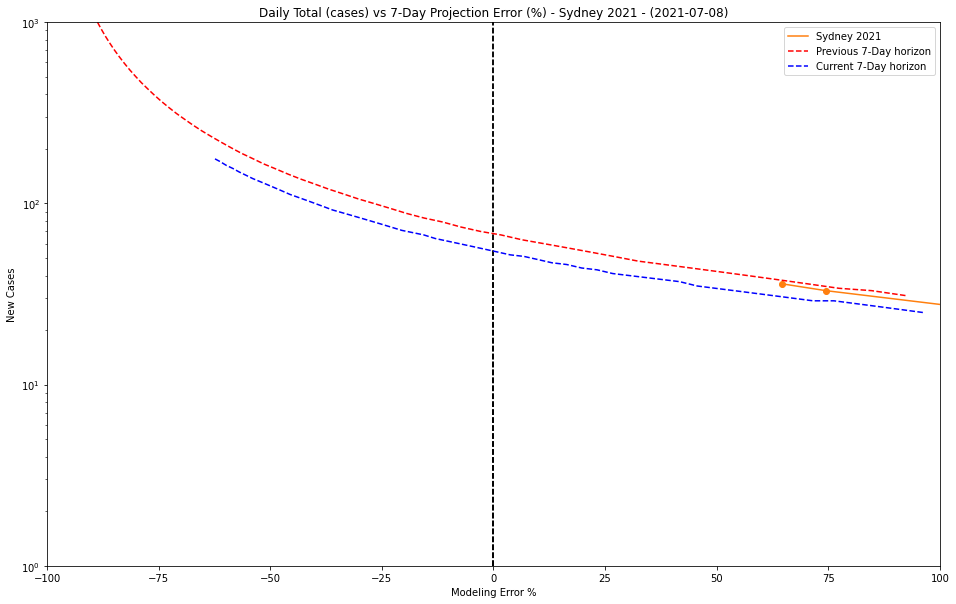

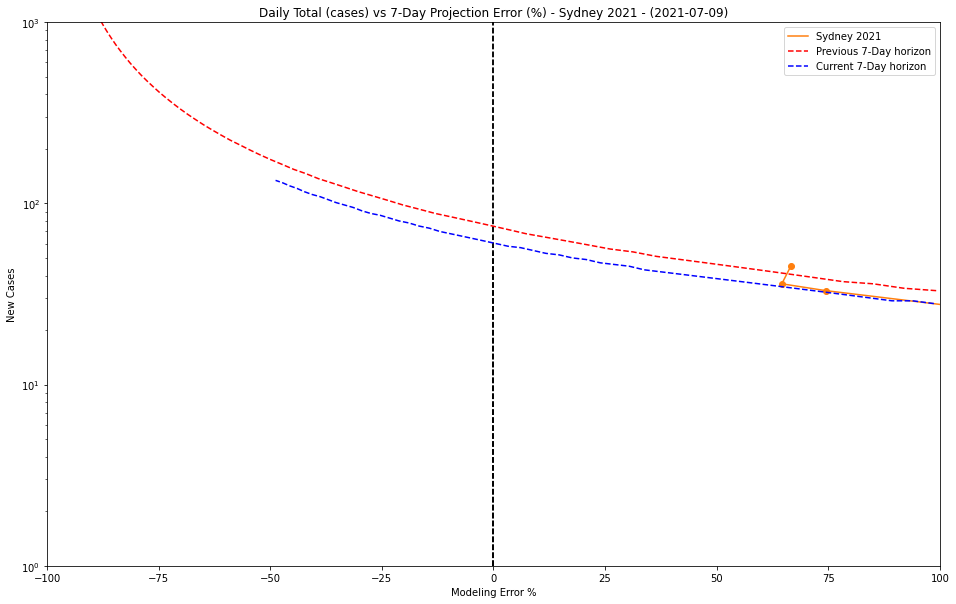

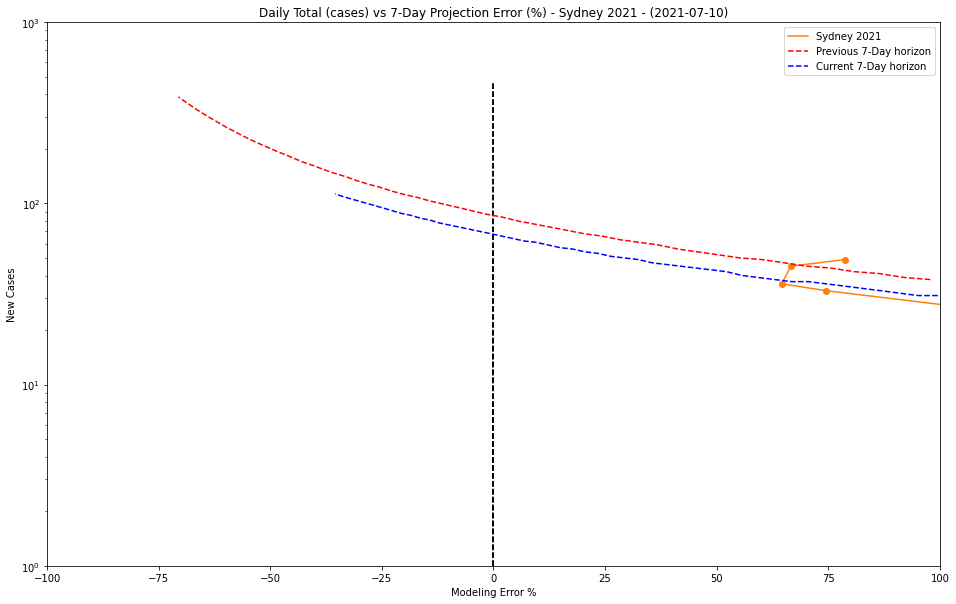

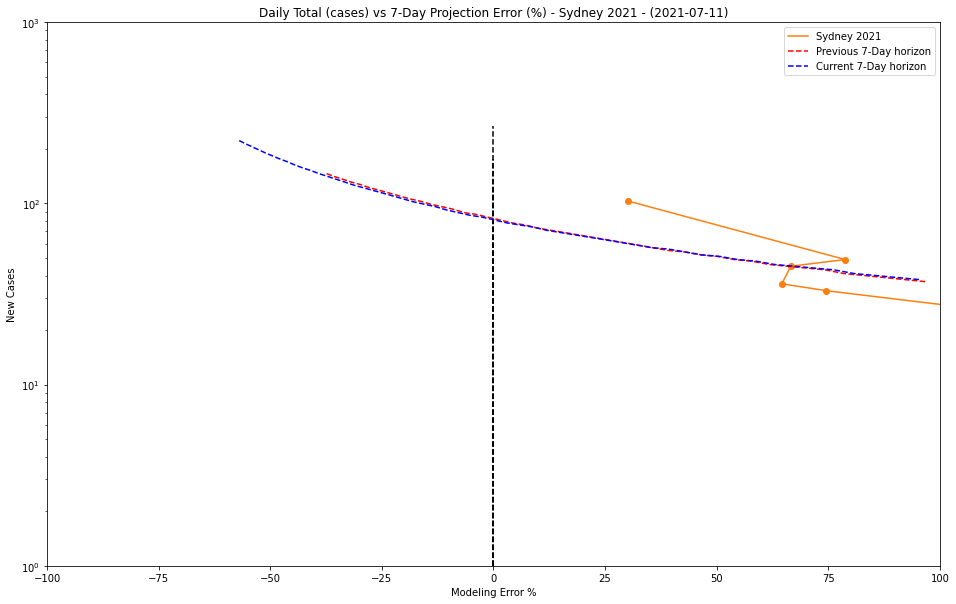

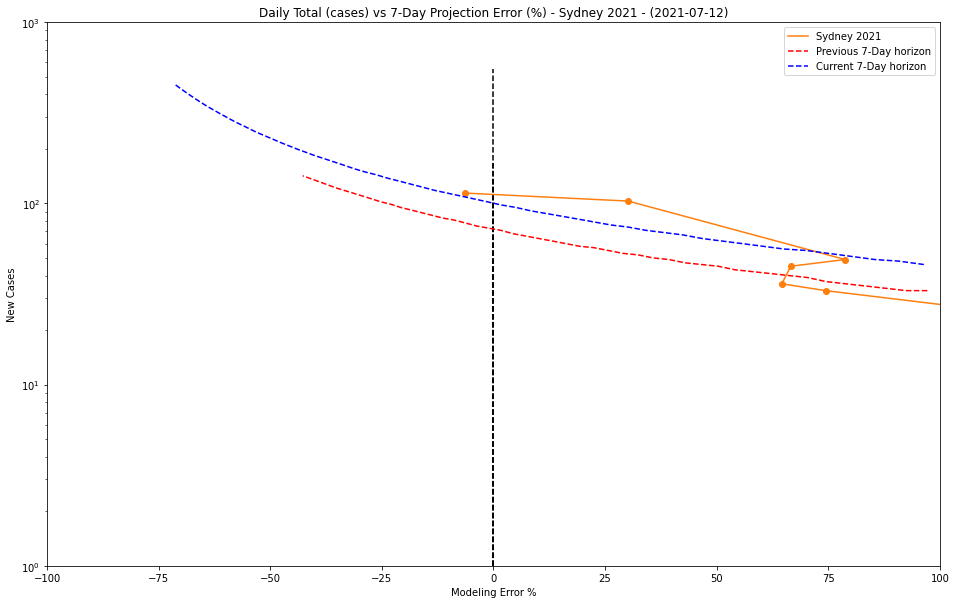

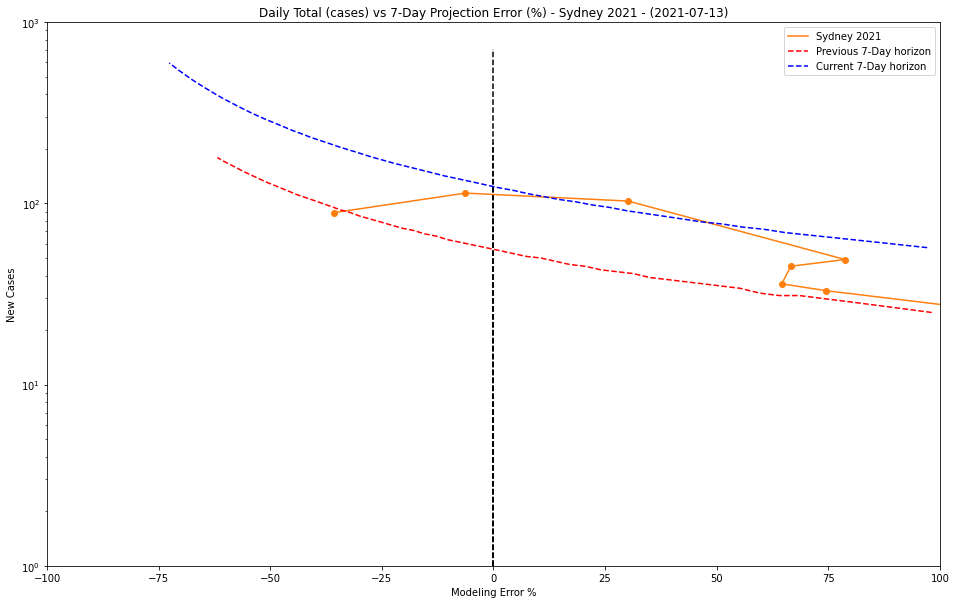

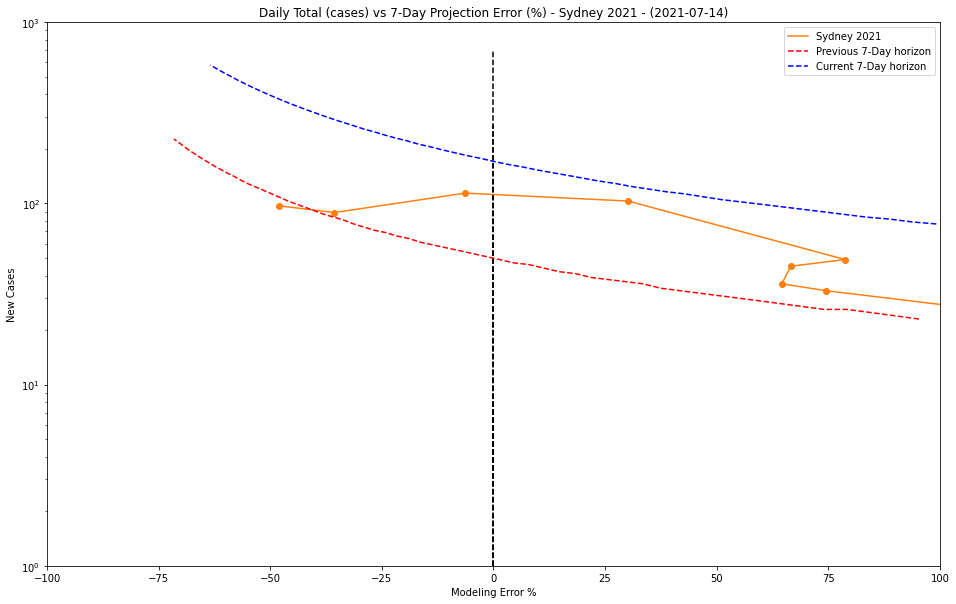

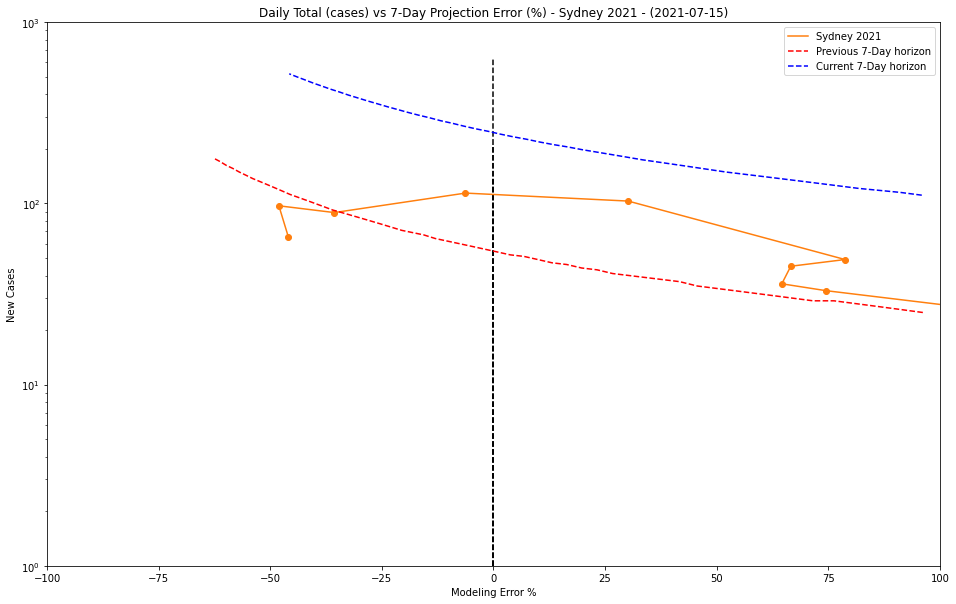

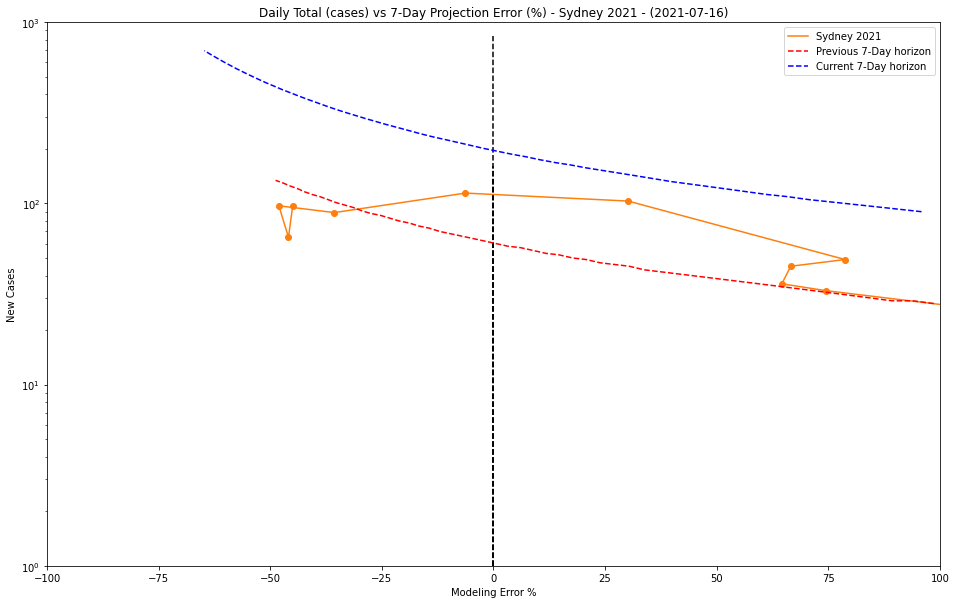

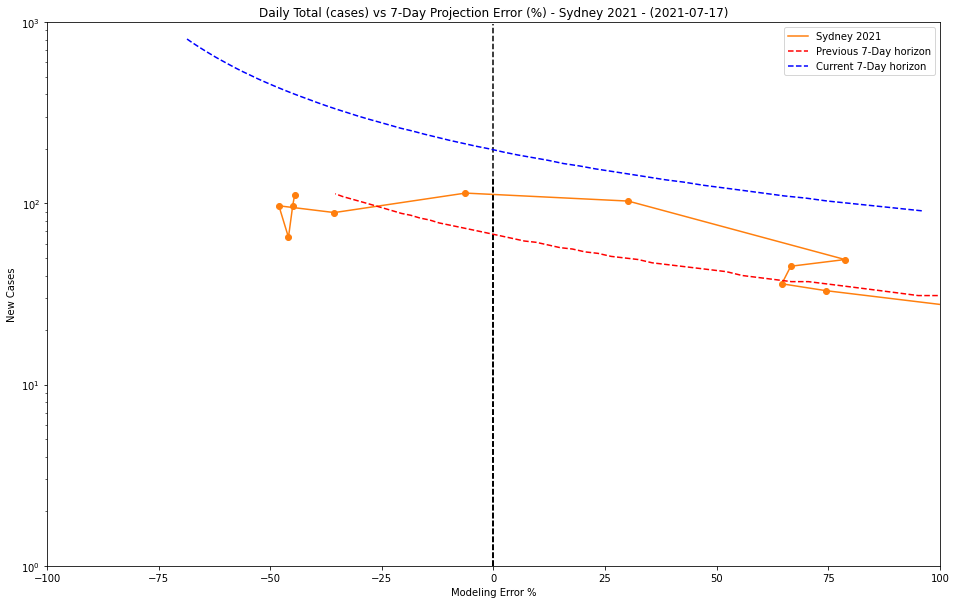

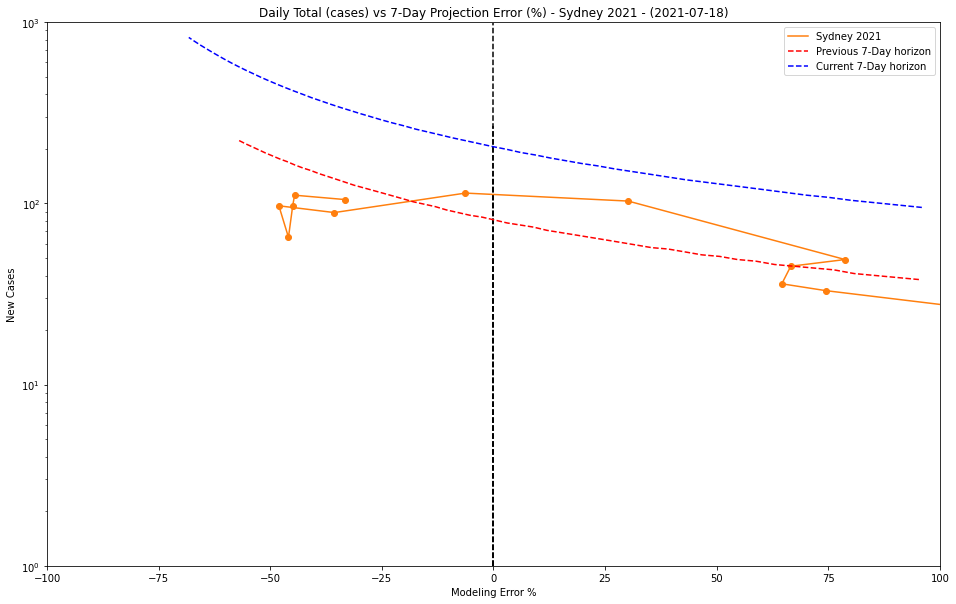

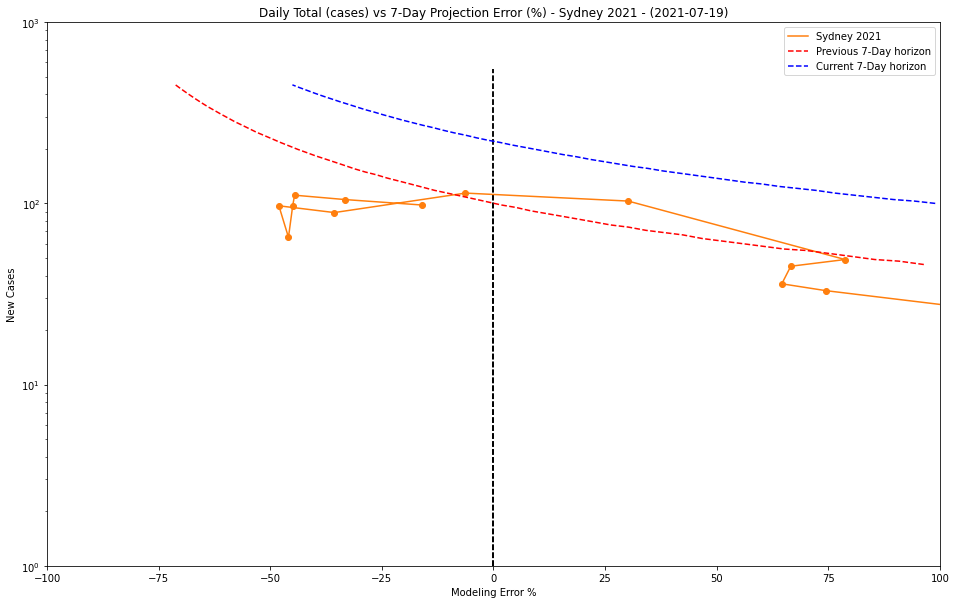

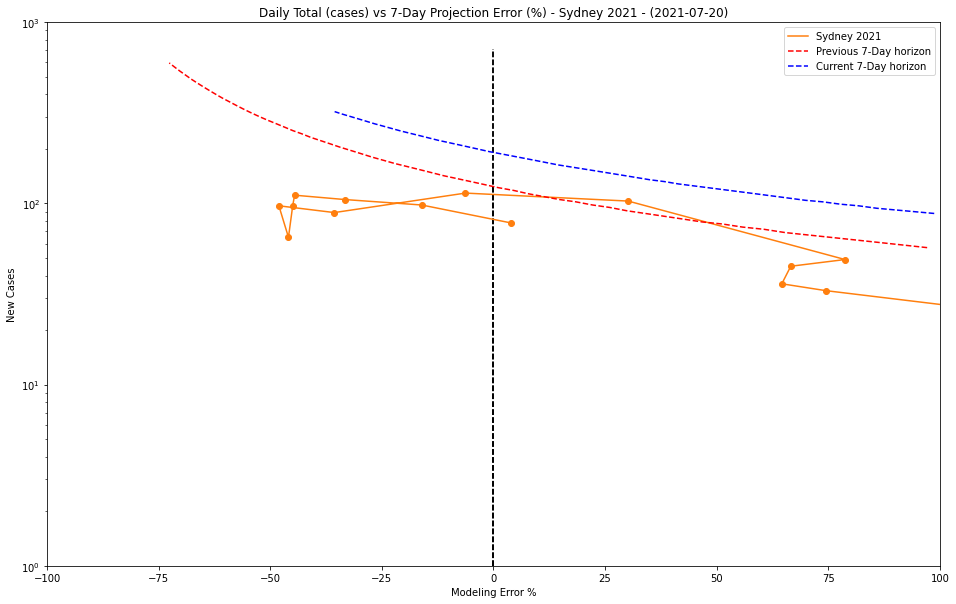

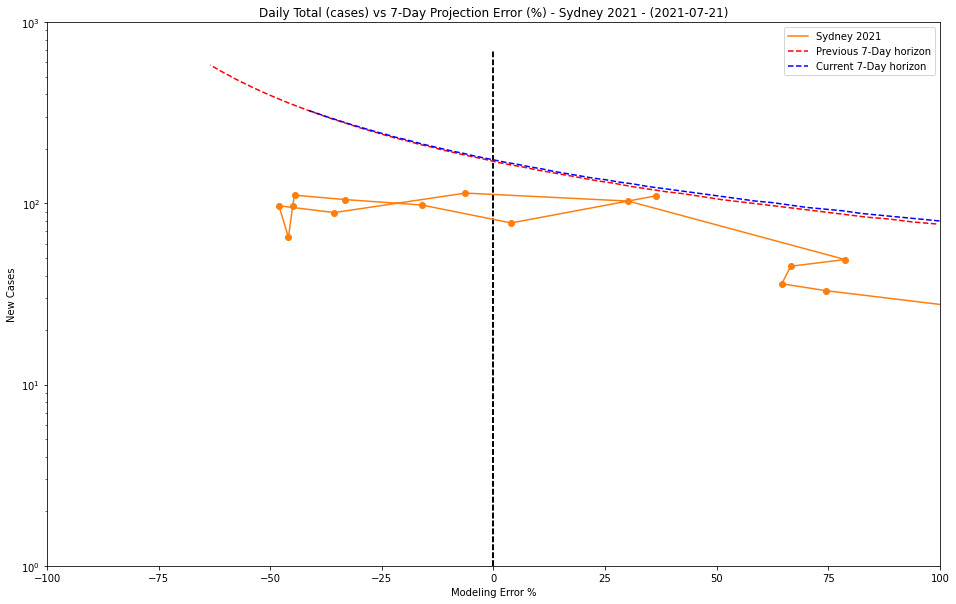

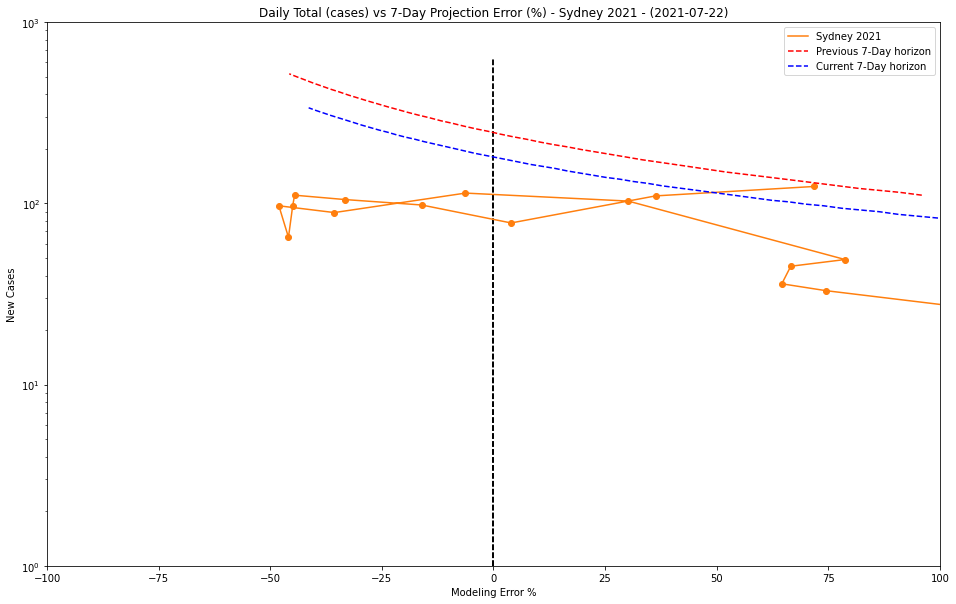

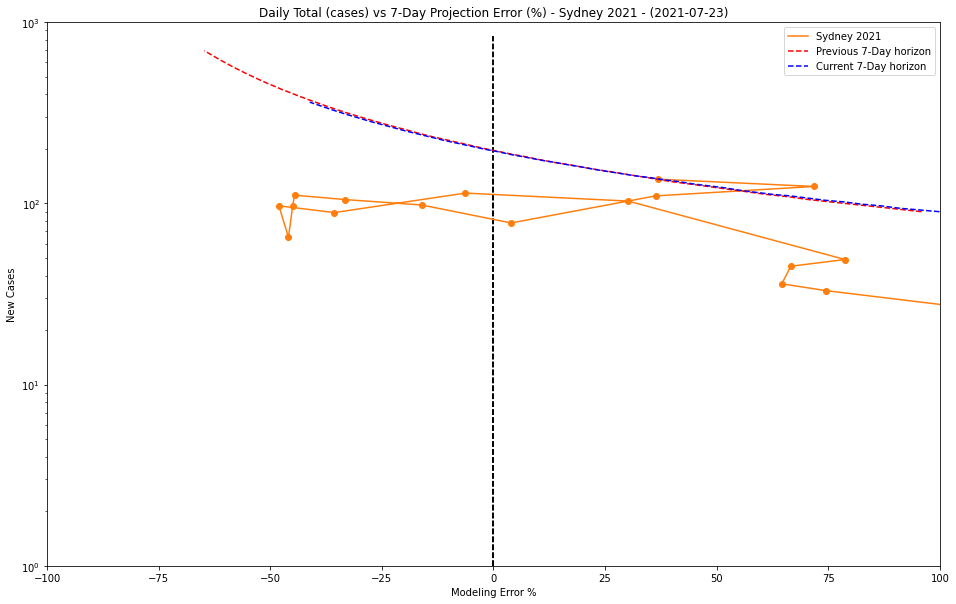

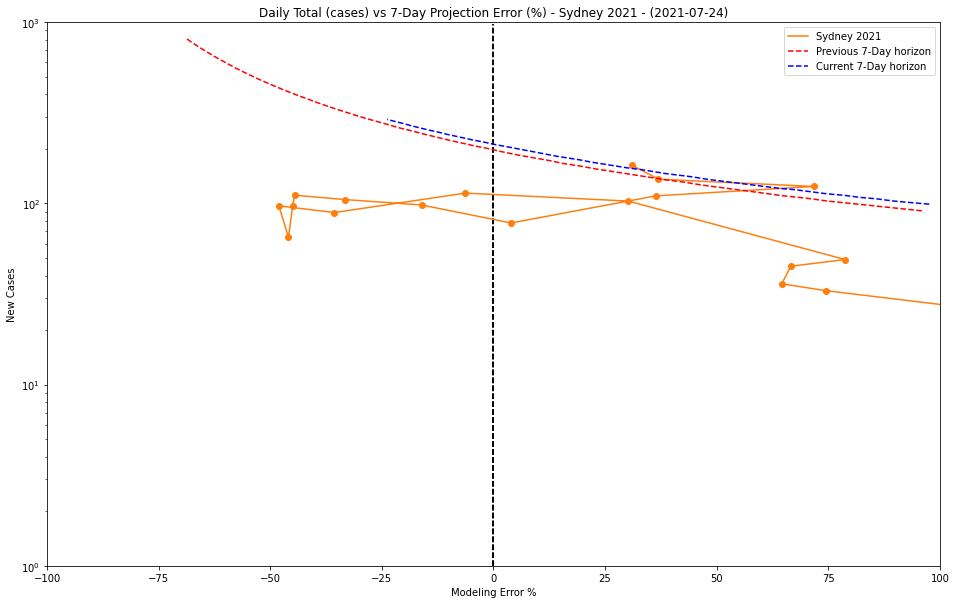

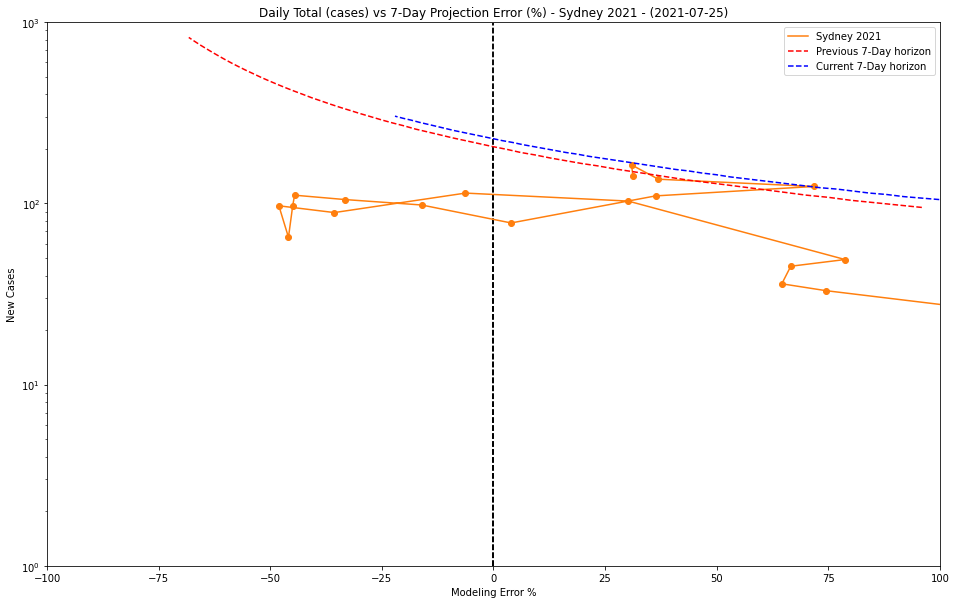

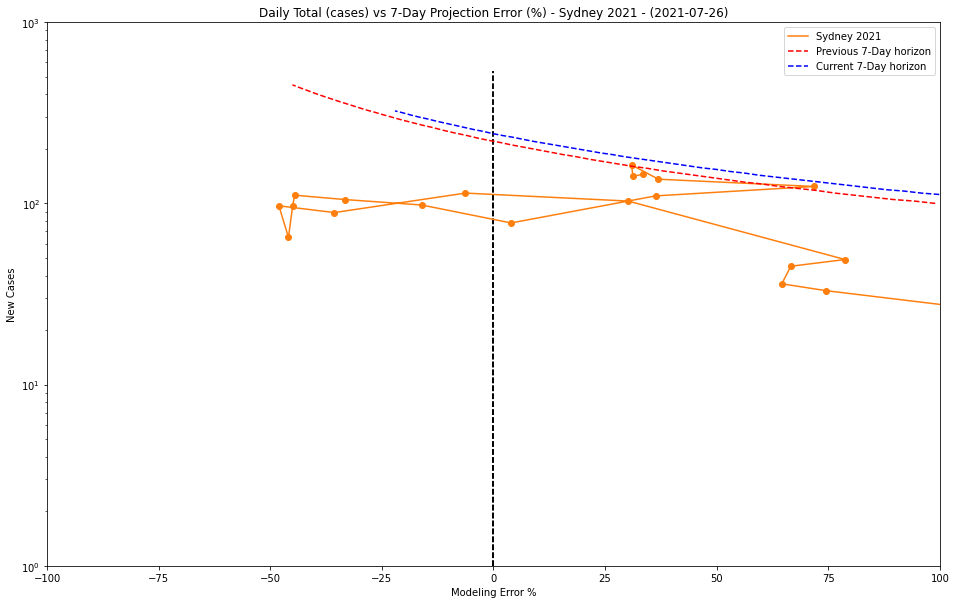

In [18]:
animate_phaseplot(
    df=bondi, 
    outbreak="Sydney 2021", 
    fn=f'archive/{RUN_DATE}/animated-hedgehog-sydney2021.gif', 
    offset=15
)
if ENABLE_MELBOURNE_ANIMATION:
    animate_phaseplot(
        df=vic_outbreak, 
        offset=20, 
        outbreak="Melbourne 2020", 
        fn=f'archive/{RUN_DATE}/animated-hedgehog-melbourne2020.gif'
    )